# APPROACH DOCUMENT

**PROBLEM UNDERSTANDING**
<p>Data Challenge
QuadPay is a payment gateway that lets consumers split purchases into 4 interest free
installments, every two weeks. The first 25% is taken when the order is received, and the
remaining 3 installments of 25% are automatically taken every 14 days. We help customers
manage their cash-flow and we help merchants increase conversion rates and average order
values.
This assignment is designed to help you become familiar with our problem domain and start to
think about which scenarios we should anticipate going forward. It gives us an opportunity to
evaluate how you approach complex problems.<p>
    
**QUESTIONS TO ANSWER**
<p>
<b>1.Which features show strong correlation with a customer’s likelihood of paying back
    installments?</b><br>
    
    Customer Credit Score was strongly correlated<br>
<b>2.Which features should be discarded? Why?</b><br>
    
    Paid for installments1
    Approved for installments
    Shipping zip, Checkout
    
<b>3.What surprised you about the results/trends observed in the data?<br><p></b>
    
    Certain customers have defaulted 10/10 times. I was hoping The defaulters age to be much younger than average non 
    defauletrs age but the difference is pretty less. The zip code was a pleasant surprise<br>
<b>4. What additional data would you like to see that might help build a better installment-<br>
    approval classifier?<br><p></b>
    
    Customer demographics, Net Worth, Salary, Employment Type(Govt, selfemployed, pvt),WorkingSector, external 
    credit,Past transactional data,family_income
<b>5. What would be your next steps to train/build a model that we could use to make real time<br>
    customer approval decisions?<br><p></b>
    
    After getting more data with more essential features, i will clean my data further by some outlier removals to make my data more robust.
    I will try and create a model with better recall and low errors by hyperparameter tuning and feature engineering.
    In the end i will keep a threshold below which a request is accepted and above which it will involve manual intervention/would not approve the request.
    
    2 applications would be created, 
    First one to create the data in the exact format the predictive model would need.
    Second would be the predictive model which would return the score/result.
    
    FLOWCHART
    Frontend-->button(trigger)->messaging-queue(eg.kafka)--(from 1 application to other)-app1(create_data)--app2(predictive_model)--decision--manual_intervention(if-needed)-->live_database for newdata-->cron(timer_model_run) to retrain the model

## How to exceute the notebook

The jupyter notebook is kept extremely basic in nature for the understanding of how the problem was approached, and what steps were taken at each and every stage, The only thing needed is to __read the excel file and edit the file path__ in **orders=pd.read_excel('orders.xlsx')** 

## Approach Towards The Problem

**OBJECTIVE:** <p>The data comprised of 10k data points for different customers and orders  and the objective of the exercise was  to be able to bifurcate the defauters from the non defaulters.</p>

## APPROACH- HOW TO GO ABOUT THE PROBLEM

1. Data was read and `basic EDA` was done, created a profile report quickly to check how th data is distributed, null values and most importantly certain warnings which helps understand which variables aren't ready to use
2.Null Value Treatment- Most nulls were in installment columns which were indirectly `TARGET` columns
3.Converting certain `warning string variables` into consistent string variables
4.Removing `redundant columns` with single value throughout, like **approved_for_installments**,**paid_installment1** & removing handful `duplicate values` on orders assuming order_ids to be unique
5.From the basic understanding of the data, `created new features`-
    i. Target variables using paid installments
    ii.AddressSimilarity
    iii.Credit Score Grouping
    iv. Customer Age grouping
    v.Billing_zip_past( Creating ZIP code importances)
    vi. Custid_past(Creating cust id importances)
    vii.Merchantid_past (creating Merchantid importances)
6.This not being a BATCH size problem we cannot create our train and test data using train_test_split and we will break our data on a certain date assuming we have past data till then, and predict accordingly
7.Some very `basic plots and graphs` to understand the distribution of the data (Could have removed some outliers to make the data noisefree- but with limited knowledge about the variables went ahead without it)
8. `Predictive Modelling`- (Focused only on one algorithm: LR)
    Used logistic Regression (Base + Tuned)
    Random Forest (Base + Tuned)
    XGboost (Base + Tuned)
    
    Undersampling and Oversampling techniques on RF.
    
    Deciding which metric or how the model has performed and what we would like to increase depends totally on the business perspective. `Logistic Regression Tuned has given the best recall. 
    Around 45% fraudulent cases were classified correctly.`

## Importing Basic Packages

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as datetime
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline

## Machine Learning packages needed ahead

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from imblearn.combine import SMOTETomek
from imblearn.ensemble import EasyEnsembleClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler

## Reading the data

In [79]:
orders=pd.read_excel('orders.xlsx')

In [80]:
orders

,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
0,42C39B,9D74A0,6881F9,147.20,2018-10-03 14:26:18.497,2018-10-03 14:26:18.997,True,626,26,95407,95407,1.0,1,1.0,1.0
1,A19AC4,2629AB,C37828,69.95,2018-09-21 16:55:03.443,2018-09-21 16:55:05.100,True,603,20,85007,85007,1.0,1,1.0,1.0
2,381AFF,793FE0,252600000000,45.00,2018-09-15 13:41:46.103,2018-09-15 13:41:47.197,True,648,41,30305-2646,30305-2646,1.0,1,1.0,1.0
3,3184A3,22C696,24FBAF,164.00,2018-10-10 00:59:25.793,2018-10-10 00:59:26.123,True,625,33,28562,28562,1.0,1,1.0,1.0
4,237711,D4E94A,6F498E,69.17,2018-09-12 22:53:08.970,2018-09-12 22:53:10.923,True,438,18,92324,92324,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,17CAD0,A00DCD,26ECA2,63.66,2018-08-29 01:09:43.860,2018-08-29 01:09:45.343,True,613,37,60134,60134,1.0,1,1.0,1.0
9996,BAD8F0,8F5B50,9C0B17,83.89,2018-09-15 15:34:30.600,2018-09-15 15:34:31.723,True,771,34,10923,10923,1.0,1,1.0,1.0
9997,70DEB3,BC35EC,268696,95.25,2018-10-05 18:04:20.447,2018-10-05 18:04:20.773,True,611,45,60636,60636,1.0,1,1.0,1.0
9998,62754,476671,C37828,79.95,2018-09-21 19:47:58.717,2018-09-21 19:48:00.650,True,611,18,87021,87021,1.0,1,1.0,1.0


In [81]:
orders.describe()

,order_amount,customer_credit_score,customer_age,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
count,10000.000000,10000.000000,10000.000000,9998.0,10000.000000,9996.000000,9423.000000
mean,146.252272,613.435900,33.544300,1.0,0.977900,0.959684,0.940359
std,167.883106,92.555118,11.933729,0.0,0.147016,0.196709,0.236834
min,4.950000,1.000000,18.000000,1.0,0.000000,0.000000,0.000000
25%,64.000000,562.000000,24.000000,1.0,1.000000,1.000000,1.000000
50%,90.765000,611.000000,30.000000,1.0,1.000000,1.000000,1.000000
75%,155.000000,664.000000,40.250000,1.0,1.000000,1.000000,1.000000
max,1936.000000,836.000000,89.000000,1.0,1.000000,1.000000,1.000000


## Pandas Profiling-Quick Basic understanding of the data

In [82]:
profile = ProfileReport(orders, title="Quadpay Profiling Report")
#can be printed -profile

### Basic Understanding of the data from the report

## Exploratory Data Analysis

### Null Value Treatment

First and Foremost i like to check if my data consists of any null/blank values which might make it difficult for me or the model to understand the problem

In [83]:
print(f'Total null values in the dataset are {orders.isnull().sum().sum()}')

Total null values in the dataset are 617


In [84]:
orders.isnull().sum()

order_id                        0
customer_id                     0
merchant_id                     0
order_amount                    0
checkout_started_at             0
credit_decision_started_at      0
approved_for_installments       0
customer_credit_score           0
customer_age                    0
customer_billing_zip           11
customer_shipping_zip          23
paid_installment_1              2
paid_installment_2              0
paid_installment_3              4
paid_installment_4            577
dtype: int64

**As most of the null variables are in the dependant variable (Sum of Paid Installments),<br>
imputing may add noise/uncertainty, and the data missing is about 5%.**<br>

So <br>
_1._ We would drop the null values<br>
_2._ We might run the same thing by keeping them<br>
_3._ Impute with most common value<br>

Can run the model for all three and analyse the difference

## Approach-1  (Throwing Nulls)

In [85]:
orders=orders.dropna().reset_index(drop=True)

**Null Values in Dependant/Target Variable** 

1. Impute data**

2. Throw away data

3. Use a classifier that can handle missing data, e.g. xgboost. 

**Some other points:**

The pattern of missing values is important, and can influence the choice of algorithm.

If dataset is noisy, imputing may increase noise.
If the null values are low in number, can remove those data points or train both with or without that data and see if the combination performs better


**Next step comes out to be feature engineering which is important to tell which features are important**

In [86]:
orders.columns

Index(['order_id', 'customer_id', 'merchant_id', 'order_amount',
       'checkout_started_at', 'credit_decision_started_at',
       'approved_for_installments', 'customer_credit_score', 'customer_age',
       'customer_billing_zip', 'customer_shipping_zip', 'paid_installment_1',
       'paid_installment_2', 'paid_installment_3', 'paid_installment_4'],
      dtype='object')

In [87]:
orders.head()

,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,approved_for_installments,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,paid_installment_1,paid_installment_2,paid_installment_3,paid_installment_4
0,42C39B,9D74A0,6881F9,147.20,2018-10-03 14:26:18.497,2018-10-03 14:26:18.997,True,626,26,95407,95407,1.0,1,1.0,1.0
1,A19AC4,2629AB,C37828,69.95,2018-09-21 16:55:03.443,2018-09-21 16:55:05.100,True,603,20,85007,85007,1.0,1,1.0,1.0
2,381AFF,793FE0,252600000000,45.00,2018-09-15 13:41:46.103,2018-09-15 13:41:47.197,True,648,41,30305-2646,30305-2646,1.0,1,1.0,1.0
3,3184A3,22C696,24FBAF,164.00,2018-10-10 00:59:25.793,2018-10-10 00:59:26.123,True,625,33,28562,28562,1.0,1,1.0,1.0
4,237711,D4E94A,6F498E,69.17,2018-09-12 22:53:08.970,2018-09-12 22:53:10.923,True,438,18,92324,92324,1.0,1,1.0,1.0


### Convering Obj Variables into string

In [88]:
orders.dtypes

order_id                              object
customer_id                           object
merchant_id                           object
order_amount                         float64
checkout_started_at           datetime64[ns]
credit_decision_started_at    datetime64[ns]
approved_for_installments               bool
customer_credit_score                  int64
customer_age                           int64
customer_billing_zip                  object
customer_shipping_zip                 object
paid_installment_1                   float64
paid_installment_2                     int64
paid_installment_3                   float64
paid_installment_4                   float64
dtype: object

In [89]:
orders.customer_id=orders.customer_id.astype('str')
orders.order_id=orders.order_id.astype('str')
orders.merchant_id=orders.merchant_id.astype('str')
orders.customer_billing_zip=orders.customer_billing_zip.astype('str')
orders.customer_shipping_zip=orders.customer_shipping_zip.astype('str')

### Converting Datetime

In [90]:
orders['checkout_started_at']=pd.to_datetime(orders['checkout_started_at'], format='%Y-%m-%d %H:%M:%S.%f')
orders['credit_decision_started_at']=pd.to_datetime(orders['credit_decision_started_at'], format='%Y-%m-%d %H:%M:%S.%f')

## Removing redundant columns

As we can see that 100% of the data falls under this specific category, hence we don't need it. All these orders were **APPROVED** for installments<p>

In [91]:
orders.paid_installment_2.value_counts(normalize=True)

1    0.977754
0    0.022246
Name: paid_installment_2, dtype: float64

In [92]:
print(f'As value counts are like this {orders.select_dtypes([bool]).value_counts()},we can drop this column')

orders.drop('approved_for_installments',axis=1,inplace=True)

As value counts are like this approved_for_installments
True                         9395
dtype: int64,we can drop this column


# Removing 9 duplicates on unique variable

In [94]:
orders=orders[orders.order_id.duplicated()==False]

# DefaulterCheck & Defaulter

In [95]:
orders['Defaulter_check']=orders['paid_installment_1']+ orders['paid_installment_2']+ orders['paid_installment_3']+ orders['paid_installment_4']
orders['Defaulter']=np.where(orders.Defaulter_check<4,'Defaulter','Non Defaulter')

## 0=Non_Defaulter, 1=Defaulter

In [96]:
orders['Defaulter_Target']=np.where(orders['Defaulter']=='Non Defaulter',0,1)

In [97]:
orders.columns

Index(['order_id', 'customer_id', 'merchant_id', 'order_amount',
       'checkout_started_at', 'credit_decision_started_at',
       'customer_credit_score', 'customer_age', 'customer_billing_zip',
       'customer_shipping_zip', 'paid_installment_1', 'paid_installment_2',
       'paid_installment_3', 'paid_installment_4', 'Defaulter_check',
       'Defaulter', 'Defaulter_Target'],
      dtype='object')

# AddressSimilarity-Fuddu

In [98]:
orders['Address_similarity']=orders.customer_billing_zip==orders.customer_shipping_zip

In [99]:
orders.groupby(['Address_similarity'])['Defaulter'].value_counts(normalize=True)

Address_similarity  Defaulter    
False               Non Defaulter    0.933661
                    Defaulter        0.066339
True                Non Defaulter    0.928475
                    Defaulter        0.071525
Name: Defaulter, dtype: float64

# CreditBinned

In [100]:
orders.groupby(['Defaulter']).agg({'customer_credit_score': 'mean','order_amount':'mean','customer_age':'mean'})

,customer_credit_score,order_amount,customer_age
Defaulter,,,
Defaulter,556.557895,143.689143,31.512782
Non Defaulter,617.604288,145.716085,33.745442


In [101]:
orders.customer_credit_score.describe()

count    9386.000000
mean      613.279139
std        93.046506
min         1.000000
25%       562.000000
50%       611.000000
75%       664.000000
max       836.000000
Name: customer_credit_score, dtype: float64

In [102]:
bins = [0,300,400,500,550,600,650,700,750,800]
orders['credit_binned'] = pd.cut(orders['customer_credit_score'], bins)

# Customer_Age

In [103]:
bins = [0,18,24,35,45,60,70]
orders['customer_age_bins'] = pd.cut(orders['customer_age'], bins)

# Billing-Zip_Importances

In [104]:
zip_data=orders[['customer_billing_zip','credit_decision_started_at','Defaulter_Target']]
zip_data=zip_data.assign(Counter=1)

zip_data=zip_data.groupby(['customer_billing_zip','credit_decision_started_at']).sum().groupby('customer_billing_zip').cumsum()[['Defaulter_Target','Counter']].reset_index()

zip_data['Past_cases_zip']=zip_data['Counter']-1
zip_data['Past_defaults_zip']=np.where(zip_data['Defaulter_Target']==0,0,zip_data['Defaulter_Target']-1)

#### Important zip-95355-4805,,customerid 04CB4C


orders[orders['customer_billing_zip']=='95355-4805']

In [105]:
zip_data=zip_data[['customer_billing_zip', 'credit_decision_started_at', 'Past_cases_zip', 'Past_defaults_zip']]
orders=pd.merge(orders,zip_data,on=['customer_billing_zip','credit_decision_started_at'],how='left')

In [106]:
orders.sort_values('Past_cases_zip')

,order_id,customer_id,merchant_id,order_amount,checkout_started_at,credit_decision_started_at,customer_credit_score,customer_age,customer_billing_zip,customer_shipping_zip,...,paid_installment_3,paid_installment_4,Defaulter_check,Defaulter,Defaulter_Target,Address_similarity,credit_binned,customer_age_bins,Past_cases_zip,Past_defaults_zip
4420,B00C24,CDF79B,E3FFE5,71.97,2018-09-08 22:04:36.177,2018-09-08 22:04:37.647,495,47,97078,97078,...,1.0,1.0,4.0,Non Defaulter,0,True,"(400, 500]","(45, 60]",0,0
5197,649834,1F94E3,C37828,74.90,2018-09-26 23:32:01.907,2018-09-26 23:32:03.453,740,30,93536,96818,...,1.0,1.0,4.0,Non Defaulter,0,False,"(700, 750]","(24, 35]",0,0
5195,F59229,DD2788,32BC4E,305.00,2018-10-02 00:08:31.770,2018-10-02 00:08:32.130,583,37,44691,44691,...,1.0,1.0,4.0,Non Defaulter,0,True,"(550, 600]","(35, 45]",0,0
5194,8CF6C3,560876,05BCA0,75.00,2018-10-09 01:42:54.360,2018-10-09 01:42:54.783,627,66,18966,18966,...,1.0,1.0,4.0,Non Defaulter,0,True,"(600, 650]","(60, 70]",0,0
5191,F2DDBA,40449,767C9E,115.00,2018-09-10 22:27:37.583,2018-09-10 22:27:38.583,574,26,46220,46220,...,1.0,1.0,4.0,Non Defaulter,0,True,"(550, 600]","(24, 35]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,33B208,ED74CD,ED5D01,94.49,2018-10-02 15:56:49.687,2018-10-02 15:56:50.077,628,35,11236,11236,...,1.0,1.0,4.0,Non Defaulter,0,True,"(600, 650]","(24, 35]",12,0
8949,03CF53,35B42F,6F498E,137.09,2018-10-07 06:40:20.700,2018-10-07 06:40:21.147,731,19,11236,13408,...,0.0,0.0,2.0,Defaulter,1,False,"(700, 750]","(18, 24]",13,1
5786,2E7ACE,B197FF,ED5D01,76.50,2018-10-07 16:42:48.813,2018-10-07 16:42:49.203,675,49,11236,11236,...,1.0,1.0,4.0,Non Defaulter,0,True,"(650, 700]","(45, 60]",14,1
1512,B80F47,B52EFE,C37828,76.16,2018-10-07 23:17:32.497,2018-10-07 23:17:33.483,670,22,11236,11236,...,1.0,1.0,4.0,Non Defaulter,0,True,"(650, 700]","(18, 24]",15,1


## CustomerId_Importance

In [109]:
cust_data=orders[['customer_id','credit_decision_started_at','Defaulter_Target']]
cust_data=cust_data.assign(Counter=1)

cust_data=cust_data.groupby(['customer_id','credit_decision_started_at']).sum().groupby('customer_id').cumsum()[['Defaulter_Target','Counter']].reset_index()

cust_data['Past_cases_cust']=cust_data['Counter']-1
cust_data['Past_defaults_cust']=np.where(cust_data['Defaulter_Target']==0,0,cust_data['Defaulter_Target']-1)
cust_data=cust_data[['customer_id', 'credit_decision_started_at', 'Past_cases_cust', 'Past_defaults_cust']]
orders=pd.merge(orders,cust_data,on=['customer_id','credit_decision_started_at'],how='left')

## Merchant_Id_Importance

In [110]:
merch_data=orders[['merchant_id','credit_decision_started_at','Defaulter_Target']]
merch_data=merch_data.assign(Counter=1)

merch_data=merch_data.groupby(['merchant_id','credit_decision_started_at']).sum().groupby('merchant_id').cumsum()[['Defaulter_Target','Counter']].reset_index()



In [111]:
merch_data.sort_values(['Defaulter_Target','merchant_id'])

,merchant_id,credit_decision_started_at,Defaulter_Target,Counter
0,01B43C,2018-09-10 00:38:22.220,0,1
1,01B43C,2018-09-11 20:00:35.573,0,2
2,01B43C,2018-09-14 01:50:00.457,0,3
3,01C9EC,2018-08-28 23:34:40.730,0,1
4,01C9EC,2018-09-13 17:42:07.237,0,2
...,...,...,...,...
7725,C37828,2018-10-13 06:08:26.900,124,1173
7726,C37828,2018-10-13 16:03:05.667,124,1174
7727,C37828,2018-10-14 04:14:36.377,124,1175
7728,C37828,2018-10-14 04:14:57.060,124,1176


In [112]:
merch_data['Past_cases_merch']=merch_data['Counter']-1

In [113]:

merch_data['Past_defaults_merch']=np.where(merch_data['Defaulter_Target']==0,0,merch_data['Defaulter_Target']-1)

In [114]:
merch_data.sort_values('Defaulter_Target')

,merchant_id,credit_decision_started_at,Defaulter_Target,Counter,Past_cases_merch,Past_defaults_merch
0,01B43C,2018-09-10 00:38:22.220,0,1,0,0
2943,6A6BC6,2018-08-30 12:54:13.100,0,2,1,0
2942,6A6BC6,2018-08-30 10:57:09.683,0,1,0,0
2832,65719E,2018-10-12 01:53:34.127,0,23,22,0
2831,65719E,2018-10-08 05:11:56.563,0,22,21,0
...,...,...,...,...,...,...
7723,C37828,2018-10-13 05:52:38.000,124,1171,1170,123
7722,C37828,2018-10-13 02:37:13.773,124,1170,1169,123
7721,C37828,2018-10-13 01:43:45.513,124,1169,1168,123
7727,C37828,2018-10-14 04:14:36.377,124,1175,1174,123


In [115]:

merch_data=merch_data[['merchant_id', 'credit_decision_started_at', 'Past_cases_merch', 'Past_defaults_merch']]
orders=pd.merge(orders,merch_data,on=['merchant_id','credit_decision_started_at'],how='left')

In [116]:
merch_data

,merchant_id,credit_decision_started_at,Past_cases_merch,Past_defaults_merch
0,01B43C,2018-09-10 00:38:22.220,0,0
1,01B43C,2018-09-11 20:00:35.573,1,0
2,01B43C,2018-09-14 01:50:00.457,2,0
3,01C9EC,2018-08-28 23:34:40.730,0,0
4,01C9EC,2018-09-13 17:42:07.237,1,0
...,...,...,...,...
9377,FED86E,2018-09-23 23:58:54.770,3,0
9378,FED86E,2018-09-24 03:10:10.537,4,0
9379,FED86E,2018-09-29 00:21:08.743,5,0
9380,FED86E,2018-09-29 17:23:40.310,6,0


## Decision Difference- MAHAFUDDU

In [117]:
orders['Decision_difference']=orders['credit_decision_started_at']-orders['checkout_started_at']

### Filter or remove noisy data

In [118]:
print(orders.checkout_started_at.max())
print(orders.checkout_started_at.min())

##Hence almost 2 months data

2018-10-14 23:50:03.233000
2018-08-28 20:48:08.970000


## Keeping a copy after eda

In [119]:
orders_eda=orders.copy()

In [120]:
orders_eda.columns

Index(['order_id', 'customer_id', 'merchant_id', 'order_amount',
       'checkout_started_at', 'credit_decision_started_at',
       'customer_credit_score', 'customer_age', 'customer_billing_zip',
       'customer_shipping_zip', 'paid_installment_1', 'paid_installment_2',
       'paid_installment_3', 'paid_installment_4', 'Defaulter_check',
       'Defaulter', 'Defaulter_Target', 'Address_similarity', 'credit_binned',
       'customer_age_bins', 'Past_cases_zip', 'Past_defaults_zip',
       'Past_cases_cust', 'Past_defaults_cust', 'Past_cases_merch',
       'Past_defaults_merch', 'Decision_difference'],
      dtype='object')

In [121]:
orders_eda=orders_eda[['order_id', 'customer_id', 'merchant_id','order_amount', 'credit_decision_started_at',
       'customer_credit_score', 'customer_age', 'customer_billing_zip',
       'customer_shipping_zip','Address_similarity', 'credit_binned',
       'customer_age_bins', 'Past_cases_zip', 'Past_defaults_zip',
       'Past_cases_cust', 'Past_defaults_cust', 'Past_cases_merch',
       'Past_defaults_merch', 'Decision_difference','Defaulter_Target']]

## Plots and Analysis

## Age & Defaulter

/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


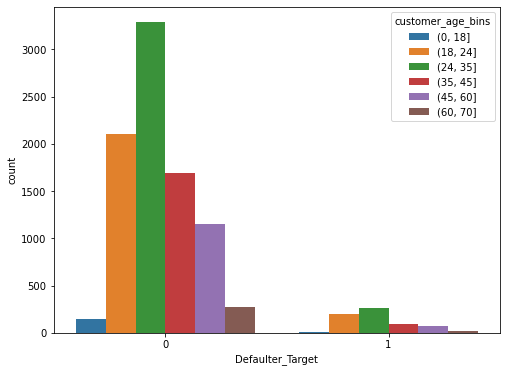

In [122]:
plt.figure(figsize=(8,6))
sns.countplot(orders_eda['Defaulter_Target'],hue=orders_eda['customer_age_bins'])
plt.show()

## Defaulter and Credit

/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


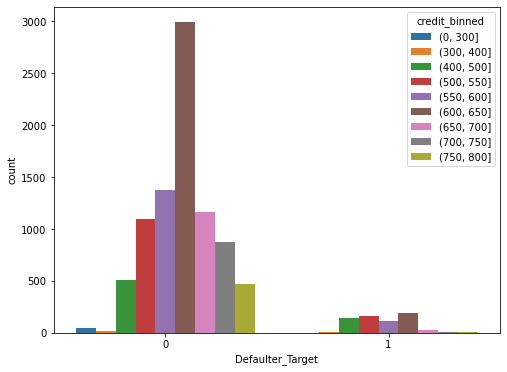

In [123]:
plt.figure(figsize=(8,6))
sns.countplot(orders_eda['Defaulter_Target'],hue=orders_eda['credit_binned'])
plt.show()

## BOX PLOTS

## Defaulter & Order_Amount

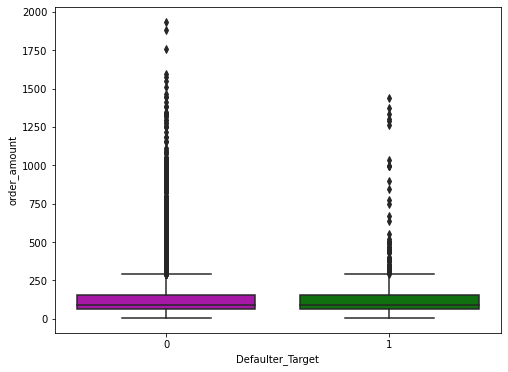

In [124]:
plt.figure(figsize=(8,6))
sns.boxplot(y=orders_eda['order_amount'],x=orders_eda['Defaulter_Target'], palette=["m", "g"])
plt.show()

## Age, Score and Defaulter

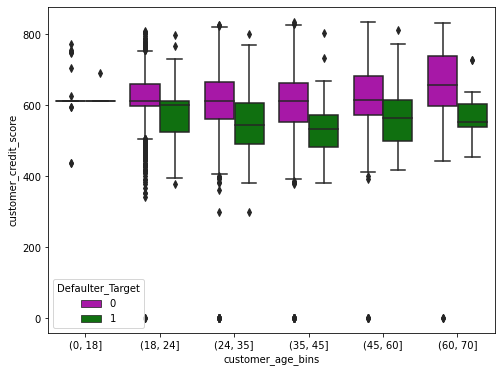

In [125]:
plt.figure(figsize=(8,6))
sns.boxplot(x=orders_eda['customer_age_bins'], y=orders_eda['customer_credit_score'],
            hue=orders_eda['Defaulter_Target'], palette=["m", "g"])
plt.show()

**Can remove some outliers using the above graph.**

## Defaulter & Age

In [126]:
orders_eda.groupby('Defaulter_Target')['customer_age'].mean()

Defaulter_Target
0    33.745442
1    31.512782
Name: customer_age, dtype: float64

In [127]:
EDA_profile = ProfileReport(orders_eda, title="Quadpay-EDA Profiling Report",explorative=True)

## PREDICTIVE MODELLING

### Filter needed data

## Creating final orders

In [128]:
final_orders=orders[['order_amount', 'credit_binned','credit_decision_started_at',
       'customer_age_bins','Past_cases_zip', 'Past_defaults_zip',
       'Past_cases_cust', 'Past_defaults_cust', 'Past_cases_merch',
       'Past_defaults_merch','Defaulter_Target' ]]
#,'cust_importance''zip_importance', 'merchant_importance'

In [129]:
final_orders['credit_binned']=final_orders['credit_binned'].astype('str')
final_orders['customer_age_bins']=final_orders['customer_age_bins'].astype('str')

<ipython-input-129-58f03fa49719>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_orders['credit_binned']=final_orders['credit_binned'].astype('str')
<ipython-input-129-58f03fa49719>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_orders['customer_age_bins']=final_orders['customer_age_bins'].astype('str')


In [130]:
final_orders=pd.get_dummies(final_orders,drop_first=True)

## Check Correlation

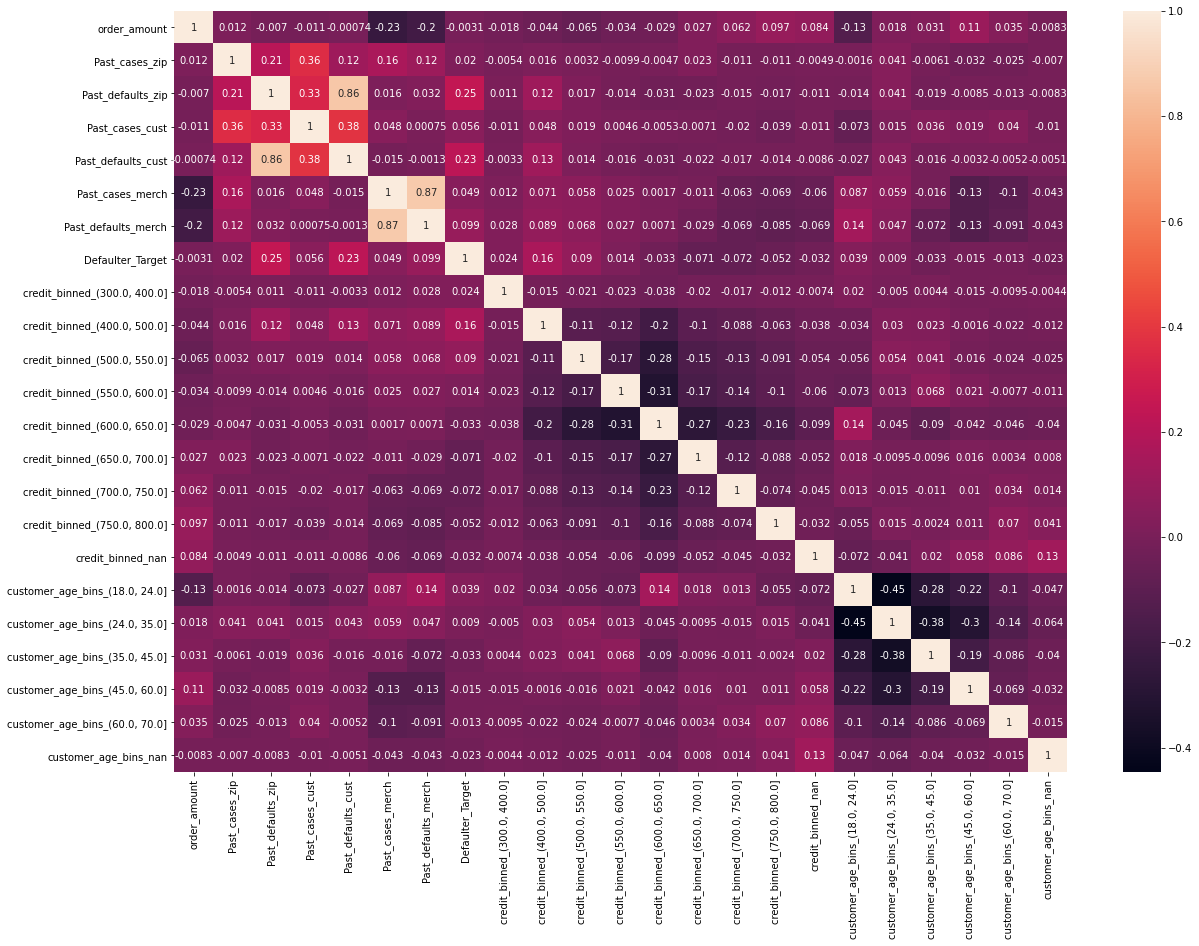

In [132]:
plt.figure(figsize=(20,14))
sns.heatmap(final_orders.corr(),annot=True)
plt.show()

#Correlated Features After EDA
#past defaults cust, past daults zip, credits

## Train Test Split

## 0=Non_Defaulter, 1=Defaulter

In [133]:
print(orders.checkout_started_at.max())
print(orders.checkout_started_at.min())

##Hence almost 2 months data

2018-10-14 23:50:03.233000
2018-08-28 20:48:08.970000


### Deciding break date

In [134]:
break_date= pd.Timestamp('2018-10-1 00:00:00.000000')

**As if we take a TrainTestSplit we will bring data from the future which will add bias to the data and give <br>extraordinary/almost perfect results which will be not the true case**

In [135]:
X_train=final_orders[final_orders['credit_decision_started_at']<= break_date]
X_test=final_orders[final_orders['credit_decision_started_at']> break_date]

In [136]:
X_train.drop('credit_decision_started_at',axis=1,inplace=True)
X_test.drop('credit_decision_started_at',axis=1,inplace=True)

/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Standardisation

In [137]:
sc = StandardScaler()

In [138]:
cols=['order_amount', 'Past_cases_zip',
       'Past_defaults_zip', 'Past_cases_cust', 'Past_defaults_cust',
       'Past_cases_merch', 'Past_defaults_merch', 'Defaulter_Target',
       'credit_binned_(300.0, 400.0]', 'credit_binned_(400.0, 500.0]',
       'credit_binned_(500.0, 550.0]', 'credit_binned_(550.0, 600.0]',
       'credit_binned_(600.0, 650.0]', 'credit_binned_(650.0, 700.0]',
       'credit_binned_(700.0, 750.0]', 'credit_binned_(750.0, 800.0]',
       'credit_binned_nan', 'customer_age_bins_(18.0, 24.0]',
       'customer_age_bins_(24.0, 35.0]', 'customer_age_bins_(35.0, 45.0]',
       'customer_age_bins_(45.0, 60.0]', 'customer_age_bins_(60.0, 70.0]',
       'customer_age_bins_nan']

### CREATING TRAIN TEST SPLIT

### Y train Y test

In [139]:
y_train=X_train.Defaulter_Target
y_test=X_test.Defaulter_Target

In [140]:
X_train = pd.DataFrame(sc.fit_transform(X_train),columns=cols)
X_test = pd.DataFrame(sc.fit_transform(X_test),columns=cols)

#### X train X test

In [141]:
X_train=X_train.drop(['Defaulter_Target'],axis=1)

X_test=X_test.drop(['Defaulter_Target'],axis=1)

# Logistic Regression

### Base

In [142]:
classifier=LogisticRegression(max_iter=1000)
classifier.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [144]:
classifier.predict_proba(X_test)[:,1]

array([0.0465721 , 0.04900889, 0.56490226, ..., 0.01894941, 0.11795333,
       0.04288435])

In [145]:


y_pred=classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2788    2]
 [ 206   18]]
0.9309887193098872
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2790
           1       0.90      0.08      0.15       224

    accuracy                           0.93      3014
   macro avg       0.92      0.54      0.56      3014
weighted avg       0.93      0.93      0.90      3014



**8% recall for 1's in the Base LR model**

### Optimized

In [62]:
y_train.value_counts()

0    5931
1     441
Name: Defaulter_Target, dtype: int64

In [63]:
#Deciding Weights (Could also be done through gridsearch)
print(5931/441)
class_weight=dict({0:1,1:13})

13.448979591836734


In [64]:
log_class=LogisticRegression(class_weight=class_weight,max_iter=10000)
grid={'C':10.0 **np.arange(-2,3),
      'penalty':['l2']}
cv=KFold(n_splits=5,random_state=None,shuffle=False)

In [147]:
np.arange(-2,3)

array([-2, -1,  0,  1,  2])

In [149]:
10.0 **np.arange(-2,3)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [150]:
2**3

8

### HyperparameterTuning

In [65]:
clf=GridSearchCV(log_class,grid,cv=cv,n_jobs=2,scoring='roc_auc')
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight={0: 1, 1: 13},
                                          max_iter=10000),
             n_jobs=2,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l2']},
             scoring='roc_auc')

In [66]:
print(f'Best roc-auc {clf.best_score_}')
print(f'Best params {clf.best_params_}')

Best roc-auc 0.7902450016100481
Best params {'C': 0.1, 'penalty': 'l2'}


In [67]:
log_class=LogisticRegression(C=10,class_weight=class_weight,max_iter=10000)
log_class.fit(X_train,y_train)

LogisticRegression(C=10, class_weight={0: 1, 1: 13}, max_iter=10000)

### Test_Predictions

In [68]:
y_pred=log_class.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.7341189836149514

### Train_Predictions

In [69]:
train_pred=log_class.predict_proba(X_train)[:,1]
roc_auc_score(y_train,train_pred)

0.7997764159336527

### Deciding Right Thresold- using train

In [70]:
precision, recall, thresholds = precision_recall_curve(y_train, train_pred)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.673822, F-Score=0.324


In [71]:
Best_Thresold=0.663822

### Adding new pred columns 

In [72]:
new_y_pred=np.where(y_pred>=Best_Thresold,1,0)

new_train_pred=np.where(train_pred>=Best_Thresold,1,0)

# Test Confusion Matrix-TestResult

In [73]:
print(confusion_matrix(y_test,new_y_pred))
print(accuracy_score(y_test,new_y_pred))
print(classification_report(y_test,new_y_pred))

[[2474  316]
 [ 133   91]]
0.8510285335102853
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2790
           1       0.22      0.41      0.29       224

    accuracy                           0.85      3014
   macro avg       0.59      0.65      0.60      3014
weighted avg       0.90      0.85      0.87      3014



## Train Confusion Matrix

In [74]:
print(confusion_matrix(y_train,new_train_pred))
print(accuracy_score(y_train,new_train_pred))
print(classification_report(y_train,new_train_pred))

[[5347  584]
 [ 245  196]]
0.8698995605775267
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5931
           1       0.25      0.44      0.32       441

    accuracy                           0.87      6372
   macro avg       0.60      0.67      0.62      6372
weighted avg       0.91      0.87      0.89      6372



### 41-46% recall for frauds after optimization

`Now after the model is created, just for the purpose of trying different techniques, below this i have worked on basic ensemble learning techniques.`<br>
**And did some undersampling and oversampling techniques which could also be used to deal with unbalanced data**

### Trying ensemple techniques- 


# Random Forest

In [76]:
## Random Forest Base

from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()
classifier.fit(X_train,y_train)

y_pred=classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2747   43]
 [ 195   29]]
0.9210351692103517
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2790
           1       0.40      0.13      0.20       224

    accuracy                           0.92      3014
   macro avg       0.67      0.56      0.58      3014
weighted avg       0.89      0.92      0.90      3014



### Optimized

In [77]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [int(x) for x in np.linspace(start= 10,stop=700, num=7)],
    'max_features': ['auto', 'sqrt'],
    'max_depth':[3],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,3],
    'bootstrap':[True,False]
}
cv=KFold(n_splits=5,random_state=None,shuffle=False)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv,n_jobs=4, verbose=2)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.93832142 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539
 0.93863539 0.93612547 0.93863539 0.93863539 0.93863539 0.93863539
 0.93863539 0.93863539 0.93816468 0.93863539 0.93863539 0.93863539
 0.93863539 0.93863539 0.93863539 0.93612362 0.93863539 0.93863539
 0.93863539 0.93863539 0.93863539 0.93863539 0.93690966 0.93863539
 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539 0.93832154
 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539
 0.93816444 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539
 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539 0.93863539
 0.93863539 0.93863539        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        n

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [3],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 125, 240, 355, 470, 585, 700]},
             verbose=2)

In [78]:
print(f'Best roc-auc {CV_rfc.best_score_}')
print(f'Best params {CV_rfc.best_params_}')

Best roc-auc 0.9386353926185859
Best params {'bootstrap': True, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}


In [79]:
class_weight

{0: 1, 1: 13}

In [80]:
rfc = RandomForestClassifier(max_depth= 5,oob_score=True,class_weight=class_weight ,max_features= 'auto', n_estimators= 240,bootstrap=True,min_samples_leaf= 3,min_samples_split=2) 
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 13}, max_depth=5,
                       min_samples_leaf=3, n_estimators=240, oob_score=True)

In [81]:
### Test_Predictions

y_pred=rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.731510016641065

In [82]:


### Train_Predictions

train_pred=rfc.predict_proba(X_train)[:,1]
roc_auc_score(y_train,train_pred)

0.814529599846458

In [83]:

### Deciding Right Thresold- using train

precision, recall, thresholds = precision_recall_curve(y_train, train_pred)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.582822, F-Score=0.352


In [84]:


Best_Thresold=0.592813

### Adding new pred columns 

new_y_pred=np.where(y_pred>=Best_Thresold,1,0)

new_train_pred=np.where(train_pred>=Best_Thresold,1,0)

In [85]:



## Test Confusion Matrix

print(confusion_matrix(y_test,new_y_pred))
print(accuracy_score(y_test,new_y_pred))
print(classification_report(y_test,new_y_pred))

[[2648  142]
 [ 167   57]]
0.8974784339747843
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2790
           1       0.29      0.25      0.27       224

    accuracy                           0.90      3014
   macro avg       0.61      0.60      0.61      3014
weighted avg       0.89      0.90      0.89      3014



In [86]:
## Train Confusion Matrix

print(confusion_matrix(y_train,new_train_pred))
print(accuracy_score(y_train,new_train_pred))
print(classification_report(y_train,new_train_pred))

[[5664  267]
 [ 295  146]]
0.9118016321406152
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5931
           1       0.35      0.33      0.34       441

    accuracy                           0.91      6372
   macro avg       0.65      0.64      0.65      6372
weighted avg       0.91      0.91      0.91      6372



## XGBoost

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
classifier=GradientBoostingClassifier()
classifier.fit(X_train,y_train)

GradientBoostingClassifier()

In [88]:
y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2733   57]
 [ 186   38]]
0.9193762441937624
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2790
           1       0.40      0.17      0.24       224

    accuracy                           0.92      3014
   macro avg       0.67      0.57      0.60      3014
weighted avg       0.90      0.92      0.90      3014



# Other Techniques that can be used on undersampled and oversampled data

## Undersampling

In [89]:
from collections import Counter
Counter(y_train)

from collections import Counter
from imblearn.under_sampling import NearMiss
ns=NearMiss(0.8)
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))



The number of classes before fit Counter({0: 5931, 1: 441})
The number of classes after fit Counter({0: 551, 1: 441})


/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=0.8 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [90]:
from sklearn.ensemble import GradientBoostingClassifier
classifier=GradientBoostingClassifier()
classifier.fit(X_train,y_train)

y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2751   39]
 [ 189   35]]
0.9243530192435302
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2790
           1       0.47      0.16      0.23       224

    accuracy                           0.92      3014
   macro avg       0.70      0.57      0.60      3014
weighted avg       0.90      0.92      0.91      3014



## Oversampling

In [91]:
import os

In [92]:
from imblearn.over_sampling import RandomOverSampler

os=RandomOverSampler(0.75)
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))



The number of classes before fit Counter({0: 5931, 1: 441})
The number of classes after fit Counter({0: 5931, 1: 4448})


/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=0.75 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [93]:
from sklearn.ensemble import GradientBoostingClassifier
classifier=GradientBoostingClassifier()
classifier.fit(X_train,y_train)

y_pred=classifier.predict(X_test)

print(pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[0,1]), 
    index=['true:yes', 'true:no'], 
    columns=['pred:yes', 'pred:no']))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

          pred:yes  pred:no
true:yes      2738       52
true:no        186       38
0.9210351692103517
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2790
           1       0.42      0.17      0.24       224

    accuracy                           0.92      3014
   macro avg       0.68      0.58      0.60      3014
weighted avg       0.90      0.92      0.91      3014



## SMOTETOMEK- Combined oversampling & undersampling

##### SMOTE is oversampling, TOMEK is undersampling

In [94]:
from imblearn.combine import SMOTETomek

os=SMOTETomek(0.5)
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

/Users/rishabhmalhotra/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


The number of classes before fit Counter({0: 5931, 1: 441})
The number of classes after fit Counter({0: 5740, 1: 2774})


In [95]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()
classifier.fit(X_train_ns,y_train_ns)

y_pred=classifier.predict(X_test)
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[0,1]), 
    index=['true:yes', 'true:no'], 
    columns=['pred:yes', 'pred:no']))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

          pred:yes  pred:no
true:yes      1846      944
true:no        109      115
0.6506303915063039
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      2790
           1       0.11      0.51      0.18       224

    accuracy                           0.65      3014
   macro avg       0.53      0.59      0.48      3014
weighted avg       0.88      0.65      0.73      3014



# Thankyou.